Сегодня мы попробуем поработать с библиотекой scikit-learn. Эта библиотека включает в себя множество алгоритмов, несколько тестовых наборов данных, функции для подсчета метрик и подбора параметров.

---

Scikit-learn появился как проект David Cournapeau на Google Summer of Code. Позднее к проекту присоединились другие разработчики, и первый релиз библиотеки состоялся 1 февраля 2010 года. Она быстро стало популярной за большое количество алгоритмов и простоту использования. sklearn полезна для экспериментов,  написания быстрых прототипов, участия в соревнованиях по анализу данных и во множестве других приложения. В тоже время, для промышленных проектов она может не подходить ввиду не оптимизированного кода и выбранного языка.



Возьмем стандартный датасет c помощью функции load_boston. Датасет содержит информацию о ценах на квартиры и какие-то параметры квартиры: близость к реке, криминогенная обстановка в районе и т.д.

In [ ]:
from sklearn.datasets import load_boston

In [ ]:
data = load_boston()
data['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

Прочитать описание датасета можно выполнив строчку: `print(data['DESCR'])`

In [ ]:
X, y = data['data'], data['target']

In [ ]:
print("Размер матрицы объектов: ", X.shape)
print("Рaзмер вектора y: ", y.shape)

Размер матрицы объектов:  (506, 13)
Рaзмер вектора y:  (506,)


Посмотрим на наши данные. Давайте построим  график того, как зависит цена от криминогенной обстановки. Для этого воспользуемся библиотекой matplotlib.

In [ ]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'Price')

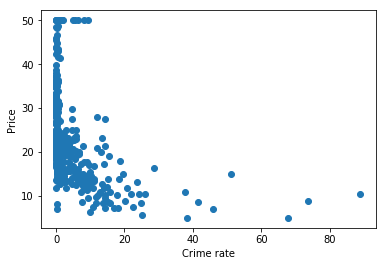

In [ ]:
plt.scatter(X[:, 0], y)
plt.xlabel('Crime rate')
plt.ylabel('Price')

Как мы видим, все закономерно, дорогие квартиры находятся в районах с низким уровнем преступности.

In [ ]:
from sklearn.model_selection import train_test_split

С помощью функции `train_test_split` разобьем выборку на `train` и `test`.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.neighbors import 
from sklearn.linear_model

В sklearn, разные методы лежат в разных модулях. Например в linear_model находятся линейные модели, в neighbors - методы основанные на ближайших соседях.

Импортируем алгоритм knn из sklearn. Работа с алгоритмами машинного обучения в библиотеке состоит из трех этапов.



1.   Создание объекта, который будет реализовывать алгоритм.
2.   Вызов `fit`: обучение модели на тренировочной подвыборке
3.   Вызов `predict`: получение предсказаний на тестовой выборке



In [ ]:
knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', p=2)

In [ ]:
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
predictions = knn.predict(X_test)

Отлично! Мы получили предсказания. Посчитаем метрику, соответствующая функция есть в scikit-learn! Будет считать средне квадратичную ошибку, так как мы решаем задачу регрессии.

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test, predictions)

46.25350980392157

Давайте попробуем сделать лучше! У нашего алгоритма есть множество гиперпараметров: количество соседей, параметры метрики и веса. Запустим поиск по сетке гиперараметров, алгоритм переберет все возможные комбинации, посчитает метрику для каждого набора и выдаст лучший набор.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid_searcher = GridSearchCV(KNeighborsRegressor(),
                             param_grid={'n_neighbors': range(1, 40, 2),
                                         'weights': ['uniform', 'distance'],
                                         'p': [1, 2, 3]},
                             cv=5)

Параметр cv=5 говорит, что во время поиска оптимальных парамертов будет использоваться кросс-валидация с 5 фолдами. Давайте вспомним, что это такое: 

![alt text](https://miro.medium.com/max/700/1*rgba1BIOUys7wQcXcL4U5A.png)
https://towardsdatascience.com/cross-validation-explained-evaluating-estimator-performance-e51e5430ff85

В нашем случае, выборка будет разделена на 5 частей и на каждой из 5 итераций, часть данных будет становиться тестовой выборкой, а другая часть - обучающей. Посчитав метрики на каждой итерации, мы сможем усреднить их в конце и получить достаточно точную оценку качества нашего алгоритма.

In [ ]:
grid_searcher.fit(X_train, y_train);

Попросим предсказание лучшей модели.

In [ ]:
best_predictions = grid_searcher.predict(X_test)

In [ ]:
mean_squared_error(y_test, best_predictions)

29.04612441223737

Давайте посмотрим на качество алгоритма в зависимости от количества соседей. Качество будем оценивать на обучающей выборке 


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

In [ ]:
metrics = []
for n in range(1, 40, 2):
  knn = KNeighborsRegressor(n_neighbors=n)
  scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
  metrics.append(np.mean(scores))

In [ ]:
from matplotlib import pyplot as plt

Text(0.5, 0, 'Number of neightbors')

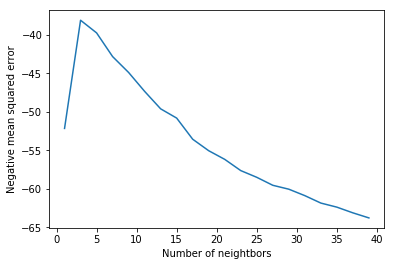

In [ ]:
plt.plot(range(1, 40, 2), metrics)
plt.ylabel('Negative mean squared error')
plt.xlabel('Number of neightbors')

Помимо готовых датасетов, в библиотеке sklearn можно найти функции для генерации искусственных данных. Давайте сгенерируем датасет для классификации и визуализируем его.

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.2)

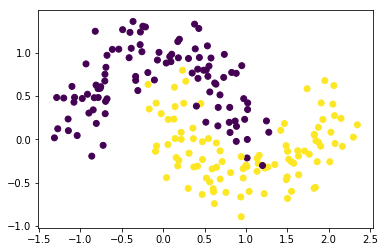

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y)

Мы получили два слегка зашумленных месяца. Давайте обучим knn на этих данных и визуализируем пространство предсказаний.



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5)

knn_clf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Для визуализации построим массив, который будет содержать в себе все точки в окрестности данных с некоторым шагом.

In [ ]:
x_grid, y_grid = np.meshgrid(np.linspace(-2.0, 3.0, 100), np.linspace(-2.0, 2.0, 100))
xy = np.stack([x_grid, y_grid], axis=2).reshape(-1, 2)
xy

array([[-2.        , -2.        ],
       [-1.94949495, -2.        ],
       [-1.8989899 , -2.        ],
       ...,
       [ 2.8989899 ,  2.        ],
       [ 2.94949495,  2.        ],
       [ 3.        ,  2.        ]])

In [ ]:
predicted = knn_clf.predict(xy)

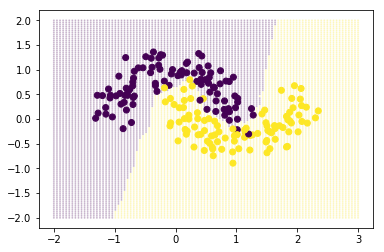

In [ ]:
plt.scatter(xy[:, 0], xy[:, 1], c=predicted, alpha=0.2, s=1)
plt.scatter(X[:, 0], X[:, 1], c=y)

На картинке вы можете увидеть исходные данные и границу, которую knn возвел между классами. Поэксперементируйте с параметром n_neighbors и посмотрите, как он влияет на итоговый результат.